In [1]:
# -*- coding: utf-8 -*-
import os
# access single GPU

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# -*- coding: utf-8 -*-
import argparse
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tqdm import tqdm

from model import DeepSEA
from model_dnase import DeepSEA_DNase
from model_TFbinding import DeepSEA_tfbinding
from model_histone import DeepSEA_histone

# load data for different tasks
from loader_task import get_train_data_by_filename_for_task
from loader_task import parse_function_for_DNase, get_valid_data_dnase, get_test_data_dnase
from loader_task import parse_function_for_TFbinding, get_valid_data_tfbinding, get_test_data_tfbinding
from loader_task import parse_function_for_Histone, get_valid_data_histone, get_test_data_histone


from utils_task import plot_loss_curve
# from utils import calculate_auroc, calculate_aupr
from utils_task import create_dirs, write2txt, write2csv

np.random.seed(0)
tf.random.set_seed(0)
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

BATCH_SIZE = 64

# 各个任务的数据分布
# dnase:(593355+564772)*2 = 2,316,254
# tf : (812544 + 803137)*2 = 3,231,362
# histone:(846613+812153)*2 = 3,317,532
CNT_dnase = 2316254
CNT_tf = 3231362
CNT_histone =3317532
# ==============for test=========================
# CNT_dnase = 640
# CNT_tf = 640
# CNT_histone =640

In [ ]:
model = DeepSEA_DNase()
model.compile(
    optimizer=tf.keras.optimizers.SGD(momentum=0.9),
    loss=tf.keras.losses.BinaryCrossentropy())
model.build(input_shape = (None, 1000, 4))
# model.summary()
w_list = model.weights
for item in w_list[3:]:
    # print(item.shape,"\n")
    print(item)

In [11]:
model_pretrain = DeepSEA()
model_pretrain.compile(
    optimizer=tf.keras.optimizers.SGD(momentum=0.9),
    loss=tf.keras.losses.BinaryCrossentropy())
model_pretrain.build(input_shape = (None, 1000, 4))
# model_pretrain.summary()
model_pretrain.load_weights('./tff_result_510_ckpt/tff_alldata_255.h5')
w_p_list = model_pretrain.weights
for item in w_p_list[3:]:
    # print(item.shape,"\n")
    print(item,"\n")

<tf.Variable 'dense_18/kernel:0' shape=(60480, 925) dtype=float32, numpy=
array([[ 1.6669261e-04,  3.4226195e-04, -1.2038135e-03, ...,
        -4.1389564e-04, -3.2631558e-04, -2.6844826e-04],
       [-9.5165789e-04,  9.4926305e-04, -7.9509441e-04, ...,
         3.8577241e-04, -9.8061406e-05, -8.7444595e-04],
       [ 1.7004727e-03,  2.3848959e-03,  1.8219907e-03, ...,
        -7.7386969e-04, -5.2650721e-04, -1.3127030e-04],
       ...,
       [-9.4160216e-04, -6.3028646e-04,  1.3665763e-03, ...,
         8.5710519e-04,  2.1178035e-04,  8.5230084e-04],
       [-7.0928154e-04,  1.3798130e-03, -5.6391937e-04, ...,
         8.0815097e-04,  3.9827084e-04,  6.0749593e-05],
       [ 1.0080455e-03, -9.2893175e-04, -2.3530284e-03, ...,
        -9.9747362e-05,  1.9027258e-03, -2.1610555e-04]], dtype=float32)> 

<tf.Variable 'dense_19/kernel:0' shape=(925, 919) dtype=float32, numpy=
array([[ 0.01593606, -0.01147352, -0.00023191, ..., -0.01163928,
         0.00205687,  0.00867934],
       [-0.0155

In [30]:
# model.get_layer(index=10) # 最后一层dense
# deepsea 一共11个layers, index：[0,10]

In [28]:
# for index in range(10):
#     weight = model.get_layer(index=index).get_weights
#     print(pre_weight,"\n")

In [27]:
for index in range(10):
    pre_weight = model_pretrain.get_layer(index=index).get_weights()
    layer = model.get_layer(index=index)
    layer.set_weights(pre_weight)
    # print(pre_weight,"\n")

In [29]:
w_list = model.weights
for item in w_list[3:]:
    # print(item.shape,"\n")
    print(item)

<tf.Variable 'dense_16/kernel:0' shape=(60480, 925) dtype=float32, numpy=
array([[ 1.6669261e-04,  3.4226195e-04, -1.2038135e-03, ...,
        -4.1389564e-04, -3.2631558e-04, -2.6844826e-04],
       [-9.5165789e-04,  9.4926305e-04, -7.9509441e-04, ...,
         3.8577241e-04, -9.8061406e-05, -8.7444595e-04],
       [ 1.7004727e-03,  2.3848959e-03,  1.8219907e-03, ...,
        -7.7386969e-04, -5.2650721e-04, -1.3127030e-04],
       ...,
       [-9.4160216e-04, -6.3028646e-04,  1.3665763e-03, ...,
         8.5710519e-04,  2.1178035e-04,  8.5230084e-04],
       [-7.0928154e-04,  1.3798130e-03, -5.6391937e-04, ...,
         8.0815097e-04,  3.9827084e-04,  6.0749593e-05],
       [ 1.0080455e-03, -9.2893175e-04, -2.3530284e-03, ...,
        -9.9747362e-05,  1.9027258e-03, -2.1610555e-04]], dtype=float32)>
<tf.Variable 'dense_17/kernel:0' shape=(925, 125) dtype=float32, numpy=
array([[ 0.00424682,  0.02217484, -0.00018594, ..., -0.04356011,
         0.04202091, -0.02521433],
       [ 0.056278

In [2]:

# =======dnase======================
def train_dnase():
    print("train_dnase() | gpu2| epoch 60| dense uint: 125| fine tuning retrain base on 510-ckpt-255| date 05-23 : 18:45 \n")
    train_dataset = get_train_data_by_filename_for_task(BATCH_SIZE,
                                                     ['./data_task/traindata-dnase-00.tfrecord',
                                                      './data_task/traindata-dnase-01.tfrecord',
                                                      './data_task/traindata-dnase-02.tfrecord',
                                                      './data_task/traindata-dnase-03.tfrecord'],
                                                     parse_function_for_DNase)
    valid_data = get_valid_data_dnase()

    # Build the model.
    model = DeepSEA_DNase()
    model.compile(
        optimizer=tf.keras.optimizers.SGD(momentum=0.9),
        loss=tf.keras.losses.BinaryCrossentropy())
    model.build(input_shape = (None, 1000, 4))
    # model.summary()

#    load pre-train best global model for FL
    model_pretrain = DeepSEA()
    model_pretrain.compile(
        optimizer=tf.keras.optimizers.SGD(momentum=0.9),
        loss=tf.keras.losses.BinaryCrossentropy())
    model_pretrain.build(input_shape = (None, 1000, 4))
    model_pretrain.load_weights('./tff_result_510_ckpt/tff_alldata_255.h5')
    for index in range(10):
        pre_weight = model_pretrain.get_layer(index=index).get_weights()
        layer = model.get_layer(index=index)
        layer.set_weights(pre_weight)
    
    # Define the callbacks. (check_pointer\early_stopper\tensor_boarder)
    # For check_pointer: we save the model in SavedModel format
    # (Weights-only saving that contains model weights and optimizer status)
    check_pointer = tf.keras.callbacks.ModelCheckpoint(
        # filepath='./result/dnase/model/ckpt',
        filepath='./result/dnase/model/dnase_ckpt_{epoch:02d}.hdf5',
        verbose=1,
        save_best_only=False,
        save_weights_only=True,
        save_freq='epoch',)
        # load_weights_on_restart=False)
    early_stopper = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        # patience=5,
        patience=10,
        verbose=0)
    tensor_boarder = tf.keras.callbacks.TensorBoard(
        log_dir='./result/dnase/logs')

    # Training the model.
    history = model.fit(
        train_dataset,
        epochs=60,
        steps_per_epoch=CNT_dnase/64,
        verbose=2,
        validation_data = valid_data,
        validation_steps=8000/64,
        callbacks=[check_pointer, early_stopper, tensor_boarder])

    # Plot the loss curve of training and validation, and save the loss value of training and validation.
    print('\n history dict: ', history.history)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    np.savez('./result/dnase/model_loss.npz', train_loss = train_loss, val_loss = val_loss)
    plot_loss_curve(train_loss, val_loss, './result/dnase/model_loss.jpg')


In [ ]:
# result date 523  |    stop

train_dnase() | gpu2| epoch 60| dense uint: 125| fine tuning retrain base on 510-ckpt-255| date 05-23 : 18:45 

Epoch 1/60

Epoch 1: saving model to ./result/dnase/model/dnase_ckpt_01.hdf5
36191/36191 - 588s - loss: 0.2171 - val_loss: 0.1245 - 588s/epoch - 16ms/step
Epoch 2/60

Epoch 2: saving model to ./result/dnase/model/dnase_ckpt_02.hdf5
36191/36191 - 531s - loss: 0.2122 - val_loss: 0.1222 - 531s/epoch - 15ms/step
Epoch 3/60

Epoch 3: saving model to ./result/dnase/model/dnase_ckpt_03.hdf5
36191/36191 - 610s - loss: 0.2108 - val_loss: 0.1210 - 610s/epoch - 17ms/step
Epoch 4/60

Epoch 4: saving model to ./result/dnase/model/dnase_ckpt_04.hdf5
36191/36191 - 591s - loss: 0.2099 - val_loss: 0.1223 - 591s/epoch - 16ms/step
Epoch 5/60

Epoch 5: saving model to ./result/dnase/model/dnase_ckpt_05.hdf5
36191/36191 - 533s - loss: 0.2091 - val_loss: 0.1264 - 533s/epoch - 15ms/step
Epoch 6/60

Epoch 6: saving model to ./result/dnase/model/dnase_ckpt_06.hdf5
36191/36191 - 600s - loss: 0.2086 - 

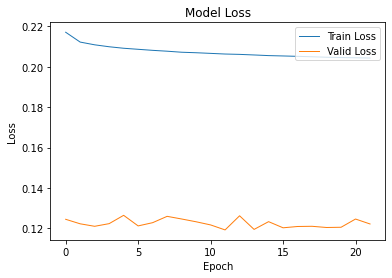

In [3]:
train_dnase()